In [11]:
# Read in goal_shot_rows.csv

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

import data_prep

In [72]:
def create_input_data_from_csv(path_to_csv):
    df = pd.read_csv(path_to_csv)

    print(len(df))
    print("HELLO WORLD 2")
    
    # get list of ilocs of rows where the 'Event' column is 'GOAL or SHOT'
    goal_shot_rows = df.loc[df['Event'].isin(['GOAL', 'SHOT'])]

    print(goal_shot_rows["Event"])

    print(list(goal_shot_rows.columns.values).count("prev_xC"))

    # shift the dataframe by 1 row
    shifted_df = df.shift(1)
    shifted_df.columns = ['prev_' + name for name in df.columns]

    print(list(shifted_df.columns.values).count("prev_xC"))

    # combine goal_shot_rows with shifted_df, but using rows from goal_shot_rows
    goal_shot_rows = pd.concat([goal_shot_rows, shifted_df.loc[goal_shot_rows.index]], axis=1)
    print(list(goal_shot_rows.columns.values).count("prev_xC"))

    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 0]
    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 5]

    val_input_data = goal_shot_rows[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]
    val_result_data = goal_shot_rows['Event']
    val_result_data = val_result_data.apply(lambda x: 1 if x == "GOAL" else 0)

    val_input_data = val_input_data.drop(columns=['Event'])
    print(list(val_input_data.columns.values).count("prev_xC"))

    # Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
    val_input_data_numeric = val_input_data[['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed', 'prev_xC', 'prev_yC']]
    val_input_data_categorical = pd.DataFrame()

    for column in ['Strength', 'Type', 'prev_Event']:
        dummy_columns = pd.get_dummies(val_input_data[column])
        val_input_data_categorical = pd.concat([dummy_columns, val_input_data_categorical], axis=1)

    for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
        dummy_columns = pd.get_dummies(val_input_data[column])

        # rename all columns with a prefix of "prev_"
        dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]
        val_input_data_categorical = pd.concat([val_input_data_categorical, dummy_columns], axis=1)
        
    # change all True/False to 1/0
    val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)

    # combine the two dataframes
    val_input_data_combined = pd.concat([val_input_data_numeric, val_input_data_categorical], axis=1)

    #set val_input_data2 to be all floats
    val_input_data_combined = val_input_data_combined.astype(float)

    columns = ['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed',
            'prev_xC', 'prev_yC', 'BLOCK', 'CHL', 'DELPEN', 'FAC', 'GIVE', 'HIT',
            'MISS', 'PENL', 'SHOT', 'STOP', 'TAKE', 'BACKHAND', 'DEFLECTED',
            'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT', '0x0',
            '3x3', '3x4', '3x5', '4x3', '4x4', '4x5', '5x3', '5x4', '5x5', '6x5',
            'prev_BLOCK', 'prev_CHL', 'prev_DELPEN', 'prev_FAC', 'prev_GIVE',
            'prev_HIT', 'prev_MISS', 'prev_PENL', 'prev_SHOT', 'prev_STOP',
            'prev_TAKE', 'prev_0x5', 'prev_3x3', 'prev_3x4', 'prev_3x5', 'prev_4x3',
            'prev_4x4', 'prev_4x5', 'prev_5x3', 'prev_5x4', 'prev_5x5', 'prev_5x6',
            'prev_BACKHAND', 'prev_DEFLECTED',
            'prev_PS-Covering puck in crease(0 min)',
            'prev_PS-Goalkeeper displaced net(0 min)',
            'prev_PS-Holding on breakaway(0 min)',
            'prev_PS-Hooking on breakaway(0 min)',
            'prev_PS-Slash on breakaway(0 min)',
            'prev_PS-Throw object at puck(0 min)',
            'prev_PS-Tripping on breakaway(0 min)', 'prev_SLAP SHOT',
            'prev_SNAP SHOT', 'prev_TIP-IN', 'prev_WRAP-AROUND', 'prev_WRIST SHOT']

    print(val_input_data_combined.shape)
    print(val_input_data_combined.columns)
    # For each column in input_data_combined, check if it exists in val_input_data_combined, if not add it as all 0s
    for column in columns:
        if column not in val_input_data_combined.columns:
                val_input_data_combined[column] = 0

    for column in val_input_data_combined.columns:
        if column not in columns:
                if column in val_input_data_combined.columns:
                    print(f"Column {column} not in columns")
                    val_input_data_combined = val_input_data_combined.drop(column, axis=1)

    # reduce val_input_data_combined to have the same columns as input_data_combined
    val_input_data_combined = val_input_data_combined[columns]

    # change all NaN numbers to 0
    val_input_data_combined = val_input_data_combined.fillna(0)

    print(val_input_data_combined.shape)

    return val_input_data_combined, val_result_data, val_input_data

# Model Evaluation


First Up, single game xG creation


In [73]:
val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20232024.csv")

print(val_input_data.columns)

415953
HELLO WORLD 2
6         SHOT
7         SHOT
9         SHOT
16        SHOT
28        SHOT
          ... 
415922    SHOT
415927    SHOT
415937    SHOT
415940    GOAL
415950    SHOT
Name: Event, Length: 80303, dtype: object
0
1
1
1


C:\Users\JoshG\AppData\Local\Temp\ipykernel_8420\1240932115.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(79805, 73)
Index(['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed',
       'prev_xC', 'prev_yC', 'BLOCK', 'CHL', 'DELPEN', 'FAC', 'GIVE', 'HIT',
       'MISS', 'PENL', 'SHOT', 'STOP', 'TAKE', 'BACKHAND', 'DEFLECTED',
       'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT', '0x0',
       '3x3', '3x4', '3x5', '4x3', '4x4', '4x5', '4x6', '5x3', '5x4', '5x5',
       '5x6', '6x5', 'prev_BLOCK', 'prev_CHL', 'prev_DELPEN', 'prev_FAC',
       'prev_GIVE', 'prev_HIT', 'prev_MISS', 'prev_PENL', 'prev_SHOT',
       'prev_STOP', 'prev_TAKE', 'prev_3x3', 'prev_3x4', 'prev_3x5',
       'prev_4x3', 'prev_4x4', 'prev_4x5', 'prev_5x3', 'prev_5x4', 'prev_5x5',
       'prev_5x6', 'prev_BACKHAND', 'prev_DEFLECTED',
       'prev_GY #8 TANEV PS-Hooking on breakaway(0 min)',
       'prev_PS-Covering puck in crease(0 min)',
       'prev_PS-Holding on breakaway(0 min)',
       'prev_PS-Hooking on breakaway(0 min)',
       'prev_PS-Slash on breakaway(0 min)',
       'prev_PS-Throw

In [75]:
filepath = '0422Model_800k.pt'
model = nn.Sequential(
    nn.Linear(72, 120),
    nn.ReLU(),
    nn.Linear(120, 60),
    nn.ReLU(),
    nn.Linear(60, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(filepath))
model.eval()
model.cpu()





Sequential(
  (0): Linear(in_features=72, out_features=120, bias=True)
  (1): ReLU()
  (2): Linear(in_features=120, out_features=60, bias=True)
  (3): ReLU()
  (4): Linear(in_features=60, out_features=1, bias=True)
  (5): Sigmoid()
)

In [76]:
print(val_input_data.columns)
# Get counts of most popular values in val_result_data
print(val_result_data.value_counts())

Index(['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed',
       'prev_xC', 'prev_yC', 'BLOCK', 'CHL', 'DELPEN', 'FAC', 'GIVE', 'HIT',
       'MISS', 'PENL', 'SHOT', 'STOP', 'TAKE', 'BACKHAND', 'DEFLECTED',
       'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT', '0x0',
       '3x3', '3x4', '3x5', '4x3', '4x4', '4x5', '5x3', '5x4', '5x5', '6x5',
       'prev_BLOCK', 'prev_CHL', 'prev_DELPEN', 'prev_FAC', 'prev_GIVE',
       'prev_HIT', 'prev_MISS', 'prev_PENL', 'prev_SHOT', 'prev_STOP',
       'prev_TAKE', 'prev_0x5', 'prev_3x3', 'prev_3x4', 'prev_3x5', 'prev_4x3',
       'prev_4x4', 'prev_4x5', 'prev_5x3', 'prev_5x4', 'prev_5x5', 'prev_5x6',
       'prev_BACKHAND', 'prev_DEFLECTED',
       'prev_PS-Covering puck in crease(0 min)',
       'prev_PS-Goalkeeper displaced net(0 min)',
       'prev_PS-Holding on breakaway(0 min)',
       'prev_PS-Hooking on breakaway(0 min)',
       'prev_PS-Slash on breakaway(0 min)',
       'prev_PS-Throw object at puck(0 min)

In [77]:
# For first 1000 rows of val_input_data_combined, predict if it's a goal or not
x = torch.tensor(val_input_data.values, dtype=torch.float32)
y = torch.tensor(val_result_data.values, dtype=torch.float32)

# for first row of val_input_data_combined, predict if it's a goal or not

probablity_table = pd.DataFrame()
nan_count = 0

for i in range(1000):
    y_pred = model(x[i])
    line = pd.DataFrame({'Goal': [y[i].item()], 'Chance': [y_pred[0].item()]})

    probablity_table = pd.concat([probablity_table, line])

# sort probablity_table by 'Chance' in descending order
# probablity_table = probablity_table.sort_values(by='Chance', ascending=False)

# write probablity_table to a csv file
probablity_table.to_csv('0421Model_probabilities.csv', index=False)

print(probablity_table)
print(nan_count)


    Goal        Chance
0    0.0  0.000000e+00
0    0.0  1.000000e+00
0    0.0  0.000000e+00
0    0.0  0.000000e+00
0    0.0  7.132925e-08
..   ...           ...
0    0.0  0.000000e+00
0    0.0  1.002758e-02
0    0.0  1.547688e-02
0    0.0  7.548039e-02
0    0.0  0.000000e+00

[1000 rows x 2 columns]
0


In [78]:
# get the accuracy of the model
accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.8981893658638


79805
79805
xC
 82.0     1332
-82.0     1284
-81.0     1255
 81.0     1242
-80.0     1166
          ... 
-98.0       20
 98.0       19
 99.0       13
-99.0       10
 100.0       4
Name: count, Length: 200, dtype: int64


<Axes: xlabel='Type', ylabel='Goal_Probability'>

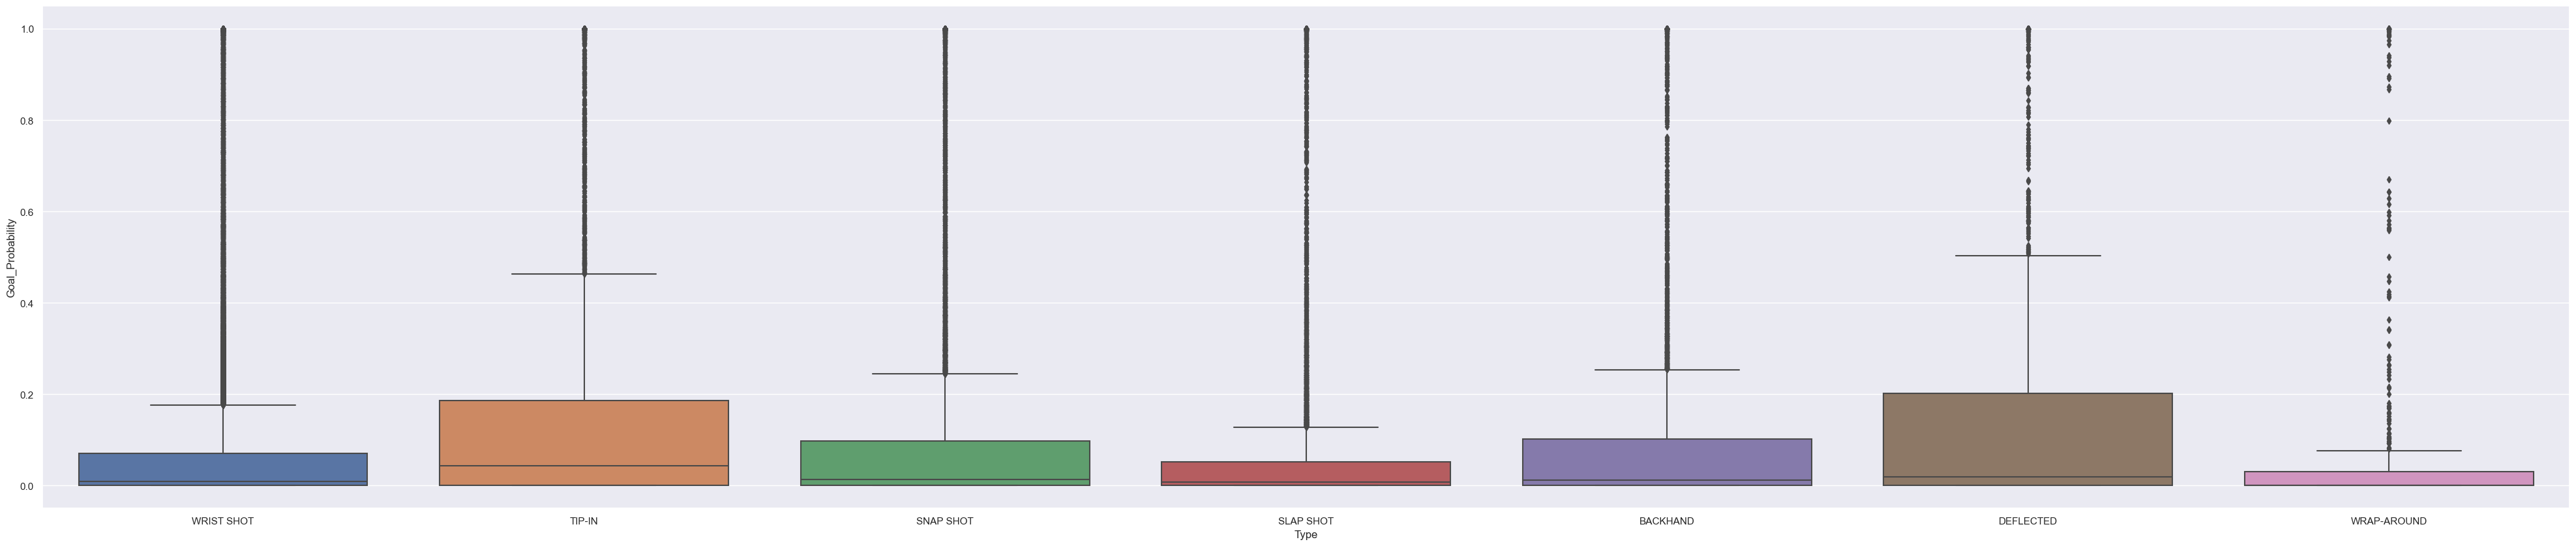

In [79]:
result = model(x)
print(len(result))


print(len(original_input))

# add the probability of a goal to val_input_data_combined
original_input['Goal_Probability'] = result.detach().numpy()


# print the values of val_input_data["Type"]
print(original_input["xC"].value_counts())

# make a boxplot of Goal_Probability vs Type
sns.set_theme(rc={'figure.figsize':(50,10)})
sns.boxplot(x=original_input["Type"], y=original_input["Goal_Probability"])
# sns.scatterplot(x=original_input["Type"], y=original_input["Goal_Probability"])


# Single Game 5v5 evaluation



In [6]:
game_pbp = pd.read_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_1713771426.csv")


